<a href="https://colab.research.google.com/github/miguelangelortizpenaranda/ortizpastorserna/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grupo 1: Bandido de K-Brazos (Distribución normal)

Autores:

- Miguel Ángel Ortiz Peñaranda
- Miguel Pastor Beltrá
- Rubén Serna

## Introducción

El bandido de k-brazos, o k-armed bandit, supone un problema clásico de aprendizaje por refuerzo. En él, disponemos de un número K de elementos que, al activarlos, nos otorgan una recompensa determinada, desconocida a priori. Es esta recompensa la que nos interesa maximizar a lo largo del tiempo, por medio de un método que, bien explore distintos "brazos" o soluciones, bien explote la solución que en un momento dado parezca la mejor, o bien mediante un compendio de ambas prácticas.




## Preparación del entorno

Para el funcionamiento de este notebook por parte de Colab, es necesario ejecutar las líneas de código que se encuentran a continuación,
las cuales se encargan de clonar el repositorio para que el código esté disponible por parte de este notebook.


In [1]:
#!rm -r ortizpastorserna/
#!git clone https://github.com/miguelangelortizpenaranda/ortizpastorserna.git
#!cd ortizpastorserna/

A continuación añadimos al path los directorios de código fuente, tanto para ejecución en Colab como para ejecución en un IDE local.

In [2]:
#@title Importamos todas las clases y funciones
import sys


# Añadir los directorios fuentes al path de Python
sys.path.append('/content/ortizpastorserna/src/eml_k_bandit')
sys.path.append('src/eml_k_bandit')

# Verificar que se han añadido correctamente
print(sys.path)

#!ls


['C:\\Users\\shera\\AppData\\Local\\Programs\\PyCharm\\plugins\\python-ce\\helpers\\jupyter_debug', 'C:\\Users\\shera\\AppData\\Local\\Programs\\PyCharm\\plugins\\python-ce\\helpers\\pydev', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\src', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\.venv\\Scripts\\python313.zip', 'C:\\Users\\shera\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'C:\\Users\\shera\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'C:\\Users\\shera\\AppData\\Local\\Programs\\Python\\Python313', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\.venv', '', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\.venv\\Lib\\site-packages', '/content/ortizpastorserna/src/eml_k_bandit', 'src/eml_k_bandit']


Realizamos los imports correspondientes a los tipos implementados de variantes del bandido de k-brazos, así como los algoritmos que se han modelado, y algunas otras librerías adicionales para representación de los resultados.

In [3]:

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy, UCB1, Softmax
from arms import ArmNormal, ArmBinomial, Bandit
from plotting import get_algorithm_label, plot_average_rewards, plot_optimal_selections, plot_regret

## Metodología de trabajo

Se propone una metodología de trabajo en la que se va a probar, tanto con distintas variantes del bandido de K-brazos (Testearemos parámetros como número de brazos o desviación), como con distintas variantes de los algoritmos que determinan en qué medida el bandido lleva a cabo una función de exploración o de explotación de los brazos, de cara a conseguir la mayor recompensa a lo largo del tiempo. Siendo así, seguiremos los siguientes pasos:

1. En cada experimento que se haga con el bandido, compararemos los algoritmos implementados (Epsilon-Greddy, UCB, Softmax), variando sus parámetros principales. Estos parámetros serán siempre iguales entre distintas ejecuciones, para asegurar la consistencia en el comportamiento de los mismos.
2. Se realizarán variaciones entre: Número de pasos (steps), número de brazos (k), y valor de la desviación en la distribución normal del bandido.
3. Para cada ejecución, se comparará el comportamiento de cada variante del algoritmo atendiendo a las métricas de: Porcentaje de elecciones óptimas en el 20% último de pasos (donde el algoritmo debe acercarse mayormente a la convergencia), y rechazo acumulado para ese algoritmo al final de la ejecución. La cantidad de pasos finales a tener en cuenta para el porcentaje de elecciones óptimas la hemos considerado así para quitarnos el tramo iniciar de los algoritmos donde el comportamiento sea mayoritariamente exploratorio.
4. Para cada experimento, se dará una valoración de los resultados obtenidos.
5. Finalmente, se darán unas conclusiones finales que indiquen qué algoritmo o algoritmos se considera que presentan un mejor comportamiento.


Fijamos la semilla aleatoria para asegurar la reproducibilidad de los resultados de las ejecuciones en distintos dispositivos.

In [4]:
seed = 1234
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

runs = 200 # El número de ejecuciones que utilizamos para promediar resultados va a ser siempre constante en nuestros experimentos

## Experimento

Este código se encarga de ejecutar un número de `runs` concretos para el problema de k-armed bandit. Utilizando una lista de algoritmos y ejecutando cada algoritmo una serie de pasos, para acabar obteniendo un promedio de recompensas por ejecución, así como el porcentaje de selecciones del brazo óptimo para dichas ejecuciones.


In [5]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    """
    Ejecuta el problema del bandido de k-brazos un número de runs concretos, una serie de pasos para cada algoritmo especificado.
    :param bandit: Implementación del bandido de k-brazos a ejecutar
    :param algorithms: Listado de algoritmos a ejecutar para esa implementación del bandido
    :param steps: Número de pasos a ejecutar para cada algoritmo individual
    :param runs: Número de ejecuciones independientes que se va a hacer para todos y cada uno de los algoritmos
    :return: Promedio de recompensas, arrepentimiento acumulado, y porcentaje de soluciones óptimas
    """
    optimal_arm = bandit.optimal_arm  # Se elige el brazo óptimo en base a la implementación del bandido. Necesario para calcular el porcentaje de selecciones óptimas.
    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    regrets = np.zeros((len(algorithms), steps)) # Matriz para almacenar el regret
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms) # Crea una instancia nueva del bandido con la distribución que especifica la implementación parada como parámetro (normal, binomial)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                optimal_reward = bandit.arms[optimal_arm].get_expected_value() # Recompensa óptima, para calcular regret

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                regrets[idx, step] += (optimal_reward - reward) # Acumulamos arrepentimiento como diferencia entre recompensa óptima y la obtenida
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                 # Modificamos optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                  optimal_selections[idx, step] += 1

    # Promediamos recompensas entre ejecuciones
    rewards /= runs

    # Promediamos arrepentimientos entre ejecuciones
    regrets /= runs
    # Calculamos arrepentimiento acumulado a lo largo del array
    cumulative_regret = np.cumsum(regrets, axis=1)

    # Calculamos el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections /= runs
    optimal_selections *= 100

    total_steps = optimal_selections.shape[1]
    final_performance = optimal_selections[:, int(total_steps * 0.8):]
    avg_optimal_rates = np.mean(final_performance, axis=1)

    total_regret = cumulative_regret[:, -1] # Coge el ultimo valor

    # Mostrar resultados
    for i, rate in enumerate(avg_optimal_rates):
        print(f"Algoritmo {get_algorithm_label(algorithms[i])}: {rate:.2f}% de elecciones óptimas en el 20% último de steps")
        print(f"Algoritmo {get_algorithm_label(algorithms[i])}: {total_regret[i]:.2f} de arrepentimiento acumulado\n")

    return rewards, cumulative_regret, optimal_selections


## Ejecución del experimento

A continuación, utilizando la función definida anteriormente, vamos a ejecutar el experimento del bandido. Esto se va a realizar para las dos variantes del bandido:
- Variante con distribución normal, con desviación 1.
- Variante con distribución binomial, con una probabilidad entre 0.1 y 0.9 por brazo, y recompensa máxima = 1 por brazo (Distribución de Bernoulli).

Adicionalmente, se va a probar con una serie de algoritmos:
- Epsilon Greedy, con valores de epsilon=[0, 0.01, 0.1], que determinan un comportamiento exploratorio cada vez mayor.
- UCB-1, con c=0.5, c=1, c=2, que determina también el peso de la componente exploratoria en el algoritmo.
- Softmax, con una temperatura de 0.5

Estos algoritmos se van a probar para cada variante del experimento, y mostraremos el promedio de recompensa y el porcentaje de decisiones acertadas para el mejor brazo en cada caso.

Vamos a crear, asimismo, una función que nos permitirá ejecutar el experimento para distinto número de brazos, y distinto número de ejecuciones, para ver si el comportamiento de los algoritmos cambia al modificar estos parámetros

In [6]:

def execute_bandit_experiment(k: int, steps: int, runs: int, bandit: Bandit):
    # Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
    algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1), UCB1(k=k, c=0.5), UCB1(k=k, c=1), UCB1(k=k, c=2), Softmax(k=k, temperature=0.5)]

    print(bandit)
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm for bandit is: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}\n")
    rewards, regrets, optimal_selections = run_experiment(bandit, algorithms, steps, runs)  # Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
    # Graficar los resultados
    plot_optimal_selections(steps, optimal_selections, algorithms)
    plot_average_rewards(steps, rewards, algorithms)
    plot_regret(steps, regrets, algorithms)


## Ejecución del experimento para Variante 1 del bandido

En primer lugar, vamos a realizar el experimento para una variante del bandido de 10 brazos, con una desviación de 1.


In [7]:
# Definimos el bandido (se comparte entre experimentos)
bandit = Bandit(arms=ArmNormal.generate_arms(k=10, mu_max=10, sigma=1.0)) # Generar un bandido con k brazos de distribución normal. El valor de máxima recompensa será 10


### Ejecución de los algoritmos para 1000 steps

Nos disponemos a ejecutar el experimento para 1000 pasos inicialmente.

Bandit with 10 arms: ArmNormal(mu=2.72, sigma=1.0), ArmNormal(mu=3.45, sigma=1.0), ArmNormal(mu=4.94, sigma=1.0), ArmNormal(mu=3.49, sigma=1.0), ArmNormal(mu=6.6, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=8.02, sigma=1.0), ArmNormal(mu=8.22, sigma=1.0), ArmNormal(mu=9.62, sigma=1.0), ArmNormal(mu=8.88, sigma=1.0)
Optimal arm for bandit is: 9 with expected reward=9.62

Algoritmo EpsilonGreedy (epsilon=0): 87.00% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 145.98 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 51.98% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.01): 1766.75 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.1): 90.47% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.1): 525.62 de arrepentimiento acumulado

Algoritmo UCB1 (c=0.5): 99.37% de elecciones óptimas en el 20% último de steps
Algoritmo UCB1 (c=0.5): 48.

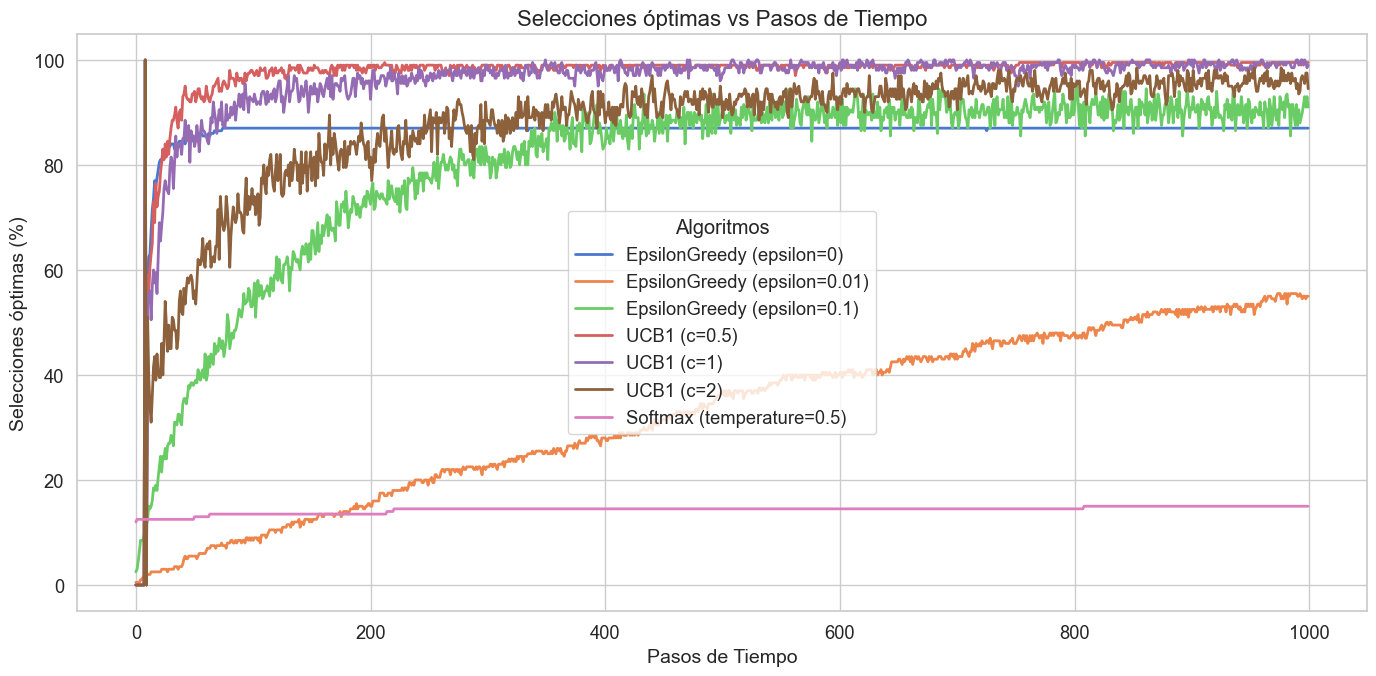

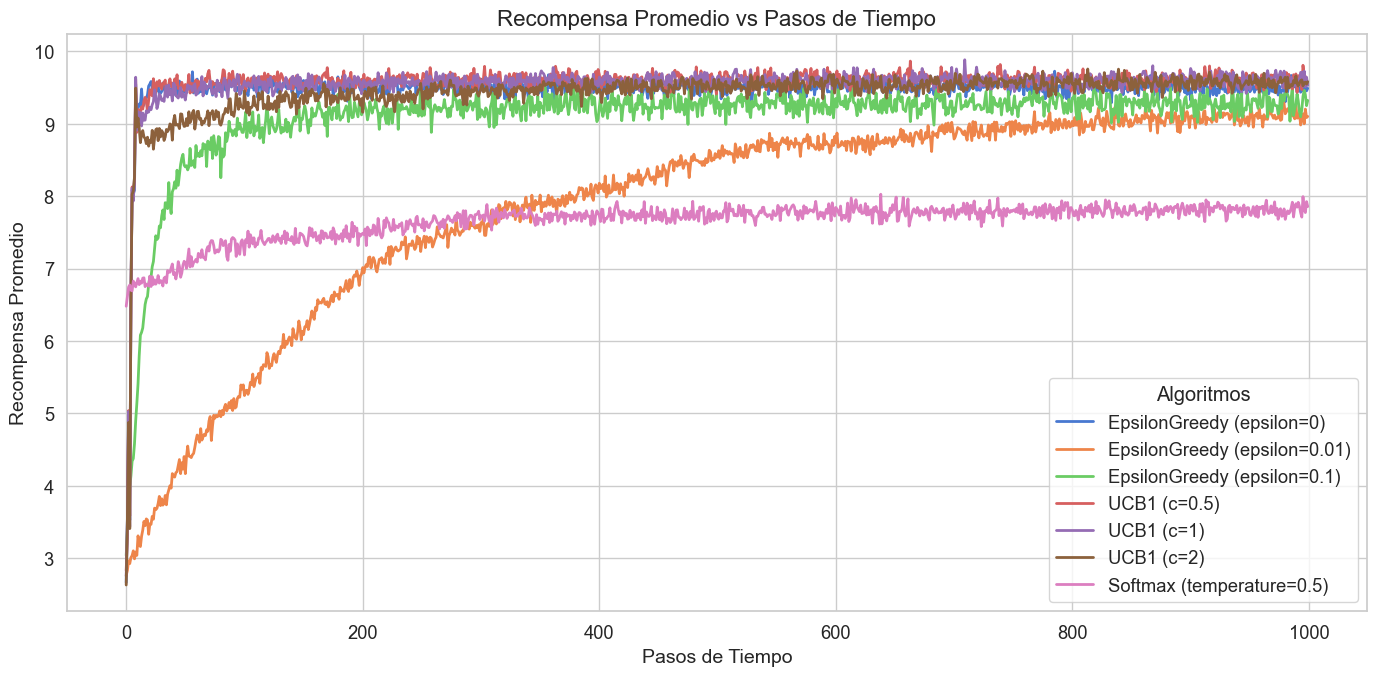

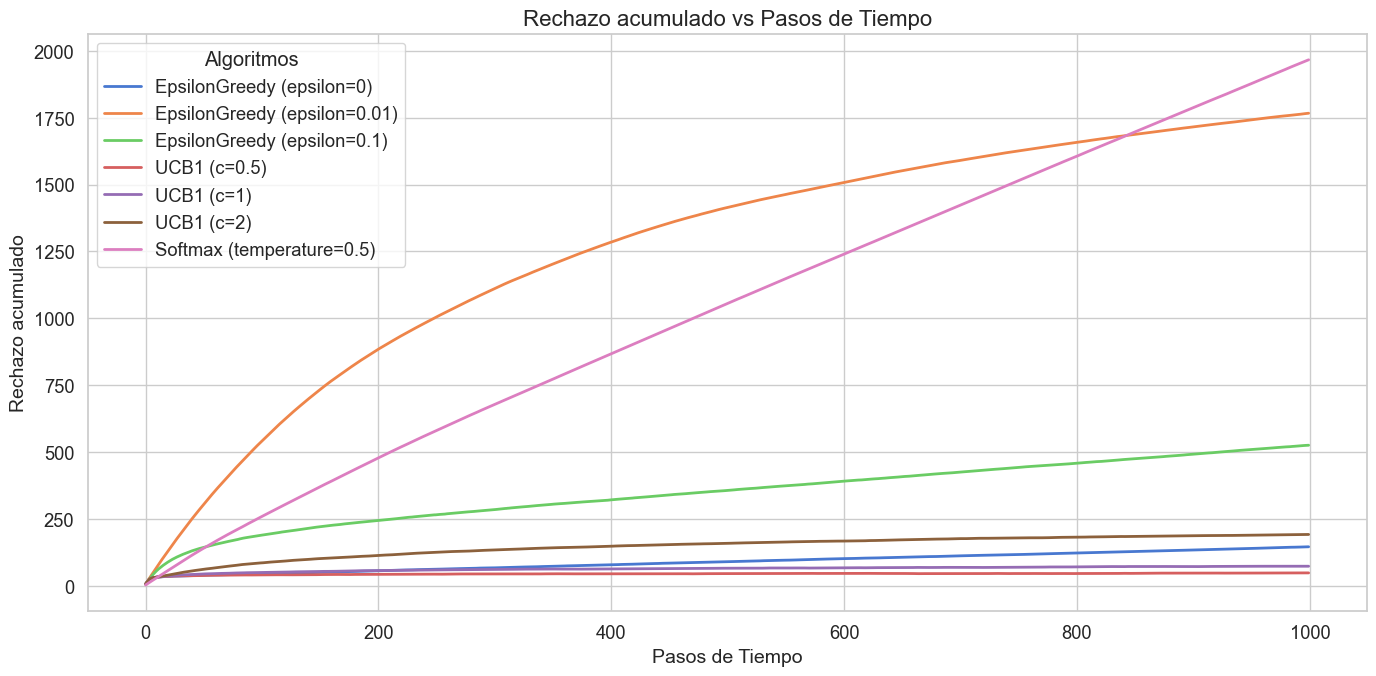

In [8]:
execute_bandit_experiment(k=10, steps=1000, runs=runs, bandit = bandit)

### Valoración de los resultados

Como se puede apreciar en las estadísticas y el las gráficas, las variantes de UCB-1 son las que presentan un mejor comportamiento, seguido muy de cerca por el algoritmo Epsilon-Greedy con una componente exploratoria de 0.1. Para Epsilon-Greedy con epsilon > 0, se puede apreciar como tarda más en encontrar el brazo óptimo que los basados en UCB-1.

La variante de Epsilon-Greedy con epsilon=0 parece que encuentra en la exploración inicial el brazo óptimo para a continuación explotarlo. Este comportamiento puede que haya sido fruto del azar y no hay que asumir que en todos los casos vaya a comportarse de esa forma.

Softmax parece que ofrece un funcionamiento bastante pobre en comparación al resto.

Concluímos, fijándonos en el mayor porcentaje de aciertos vs menor arrepentimiento acumulado, que UCB-1 con c=0.5 es el que mejor se ha comportado.

### Ejecución de los algoritmos para 1000 steps

A continuación, vamos a repetir el experimento para 2000 pasos, manteniendo el número de runs.

Bandit with 10 arms: ArmNormal(mu=2.72, sigma=1.0), ArmNormal(mu=3.45, sigma=1.0), ArmNormal(mu=4.94, sigma=1.0), ArmNormal(mu=3.49, sigma=1.0), ArmNormal(mu=6.6, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=8.02, sigma=1.0), ArmNormal(mu=8.22, sigma=1.0), ArmNormal(mu=9.62, sigma=1.0), ArmNormal(mu=8.88, sigma=1.0)
Optimal arm for bandit is: 9 with expected reward=9.62

Algoritmo EpsilonGreedy (epsilon=0): 87.50% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 225.39 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 74.75% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.01): 2023.80 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.1): 91.00% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.1): 848.21 de arrepentimiento acumulado

Algoritmo UCB1 (c=0.5): 99.42% de elecciones óptimas en el 20% último de steps
Algoritmo UCB1 (c=0.5): 53.

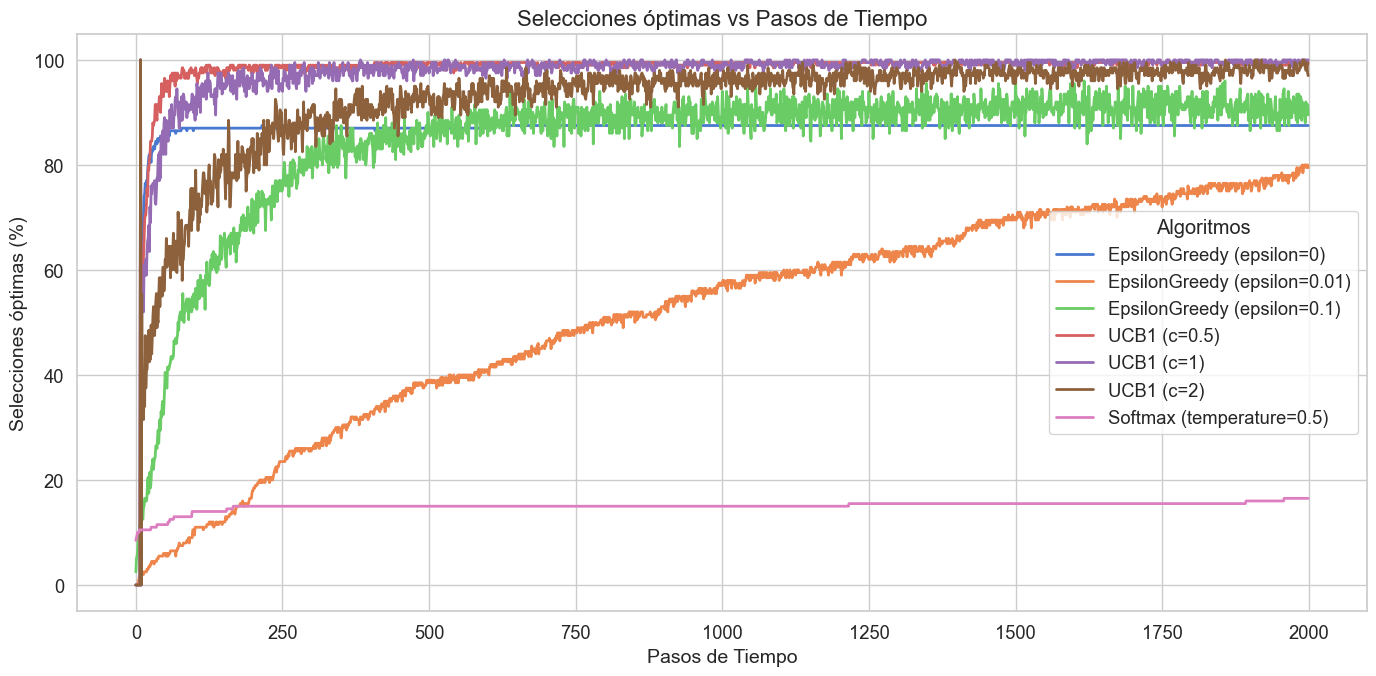

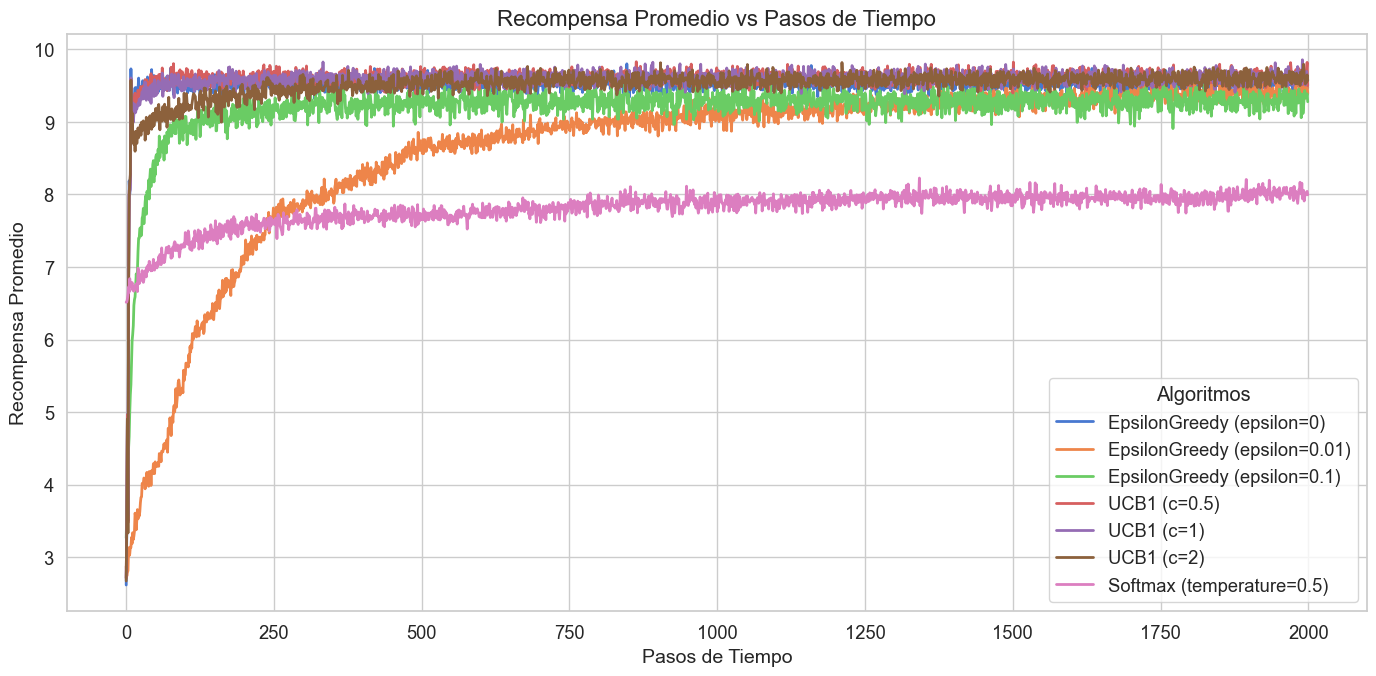

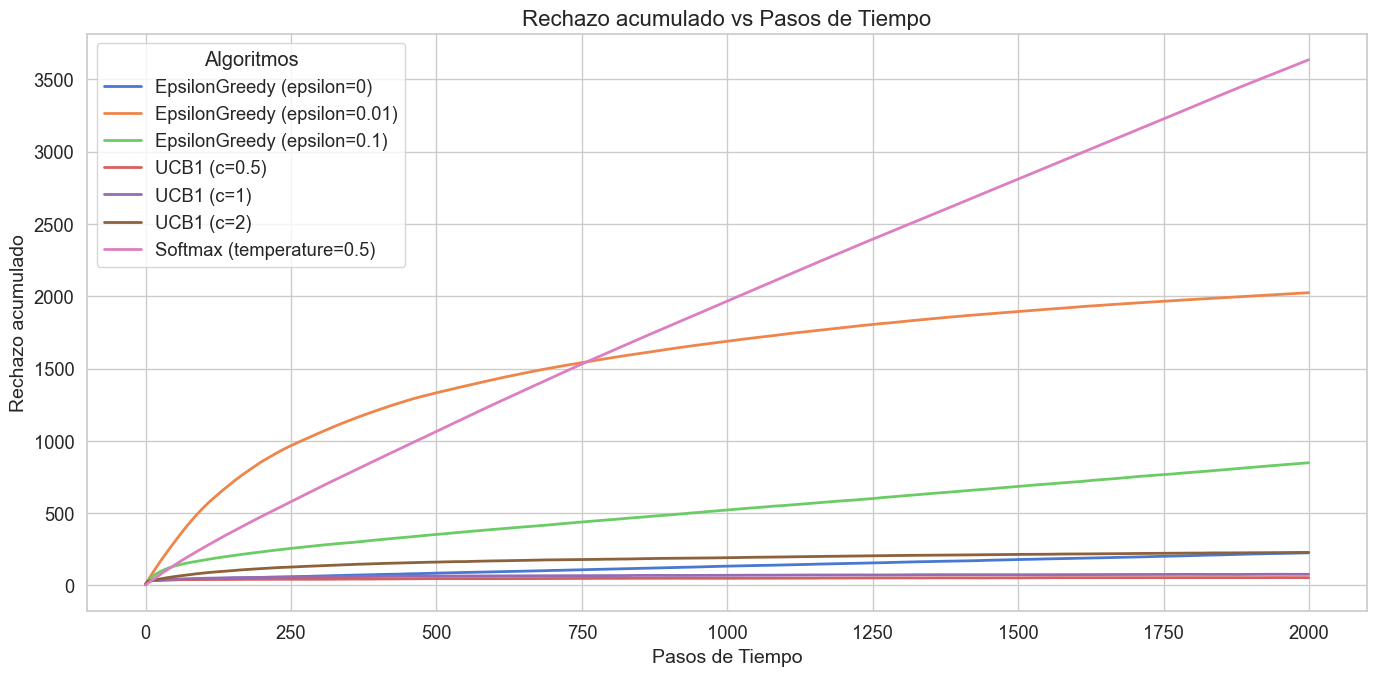

In [9]:
execute_bandit_experiment(k=10, steps=2000, runs=runs, bandit=bandit)


### Valoración de los resultados

En esta ejecución se puede corroborar lo que hemos comentado en el apartado anterior. En este caso, Epsilon-Greedy con epsilon=0 se ha estancado en un brazo que ha considerado óptimo en un principio pero que ha resultado ser subóptimo, con lo que el promedio de aciertos, como se puede ver, se ha mantenido constante tras esa fase inicial de exploración.

En las otras variantes con epsilon > 0, se observa como sobre todo para epsilon = 0.1 se acaba consiguiendo un porcentaje de aciertos bastante alto, casi equiparable a las variantes de UCB-1.

Estas últimas han sido una vez más las que mejor desempeño han aportado, destacando aquellas con c=0.5 y c=1 que son las que mejor resultado han obtenido.

## Ejecución del experimento para Variante 2 del bandido

Nos disponemos a realizar el experimento para un bandido de 20 brazos, con una desviación de 1. Vamos a realizar el experimento para un total de 1000 y 2000 pasos, al igual que en el apartado anterior.

In [10]:
# Definimos el bandido (se comparte entre experimentos)
bandit = Bandit(arms=ArmNormal.generate_arms(k=20, mu_max=10, sigma=1.0)) # Generar un bandido con k brazos de distribución normal. El valor de máxima recompensa será 10


### Ejecución de los algoritmos para 1000 steps

Vamos a llevar a cabo el experimento con la nueva variante del bandido para 1000 pasos.

Bandit with 20 arms: ArmNormal(mu=1.76, sigma=1.0), ArmNormal(mu=2.88, sigma=1.0), ArmNormal(mu=3.0, sigma=1.0), ArmNormal(mu=4.11, sigma=1.0), ArmNormal(mu=5.59, sigma=1.0), ArmNormal(mu=5.95, sigma=1.0), ArmNormal(mu=4.49, sigma=1.0), ArmNormal(mu=5.17, sigma=1.0), ArmNormal(mu=7.02, sigma=1.0), ArmNormal(mu=7.29, sigma=1.0), ArmNormal(mu=3.96, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=4.74, sigma=1.0), ArmNormal(mu=7.43, sigma=1.0), ArmNormal(mu=7.91, sigma=1.0), ArmNormal(mu=8.63, sigma=1.0), ArmNormal(mu=5.34, sigma=1.0), ArmNormal(mu=2.11, sigma=1.0), ArmNormal(mu=3.3, sigma=1.0), ArmNormal(mu=7.62, sigma=1.0)
Optimal arm for bandit is: 12 with expected reward=8.8

Algoritmo EpsilonGreedy (epsilon=0): 63.01% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 165.52 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 32.68% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.01): 1880.2

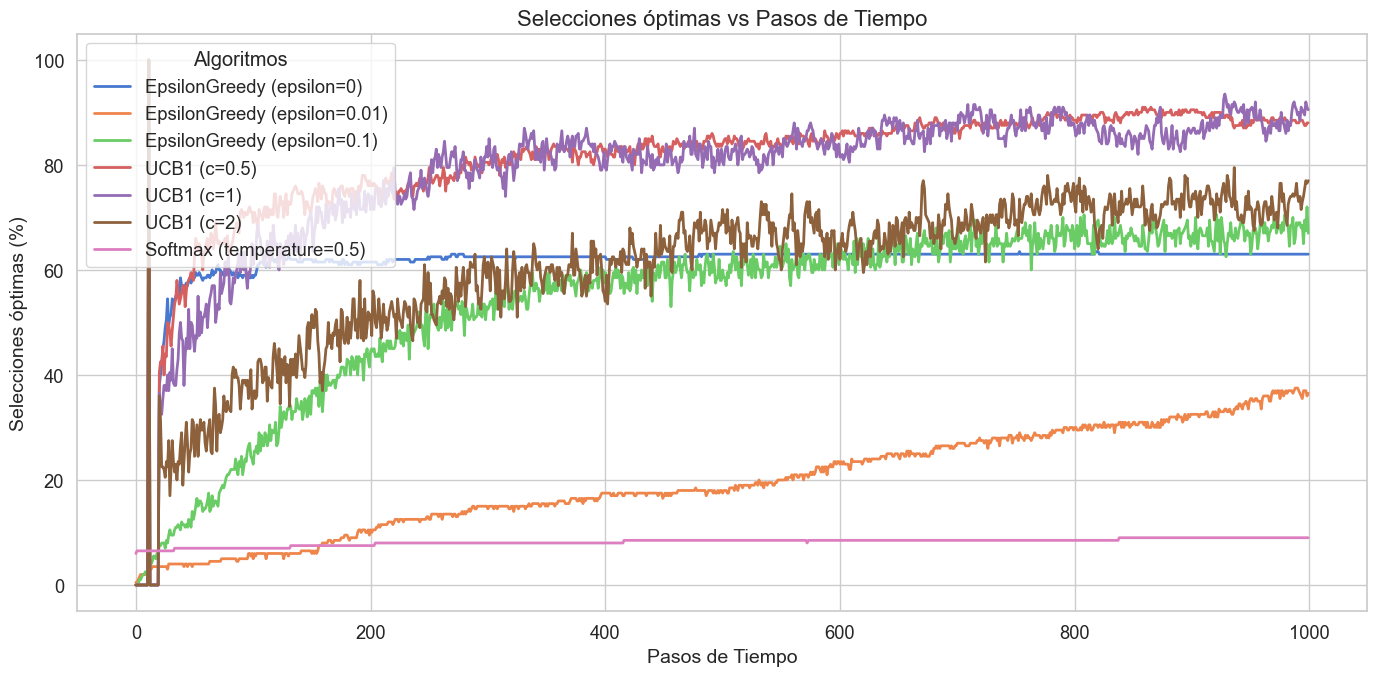

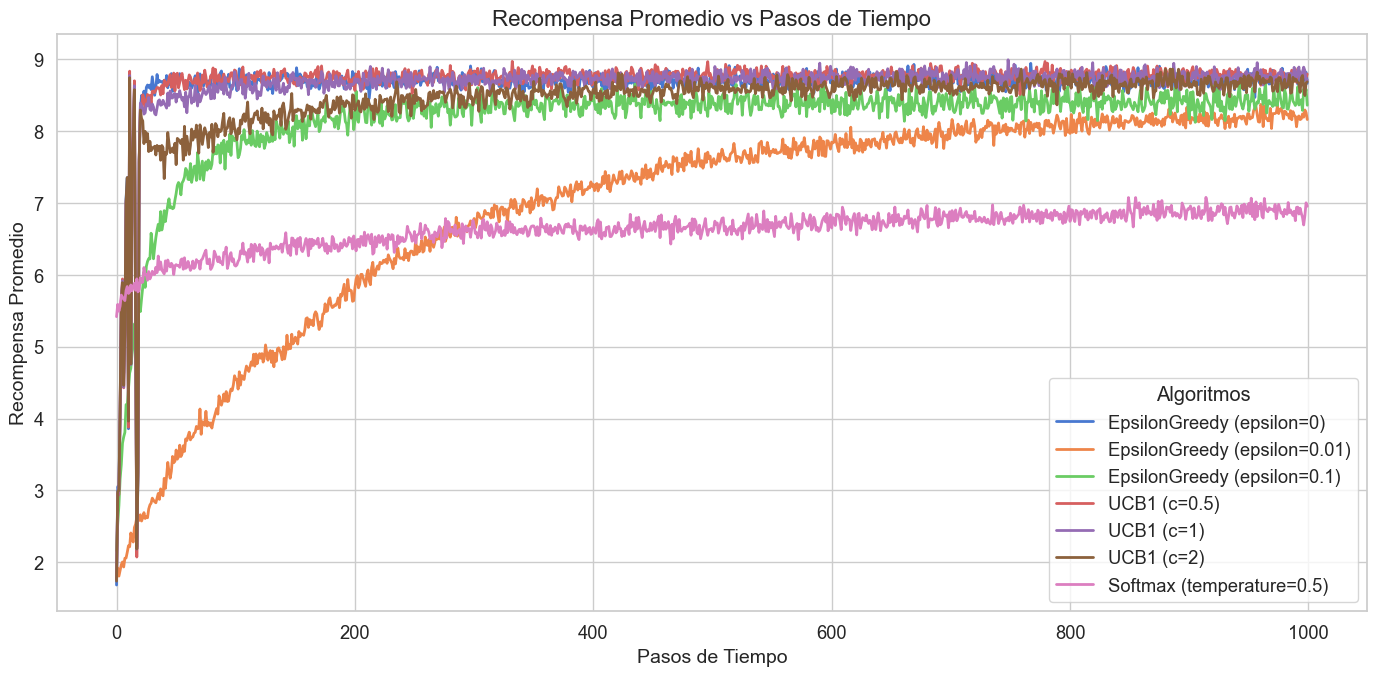

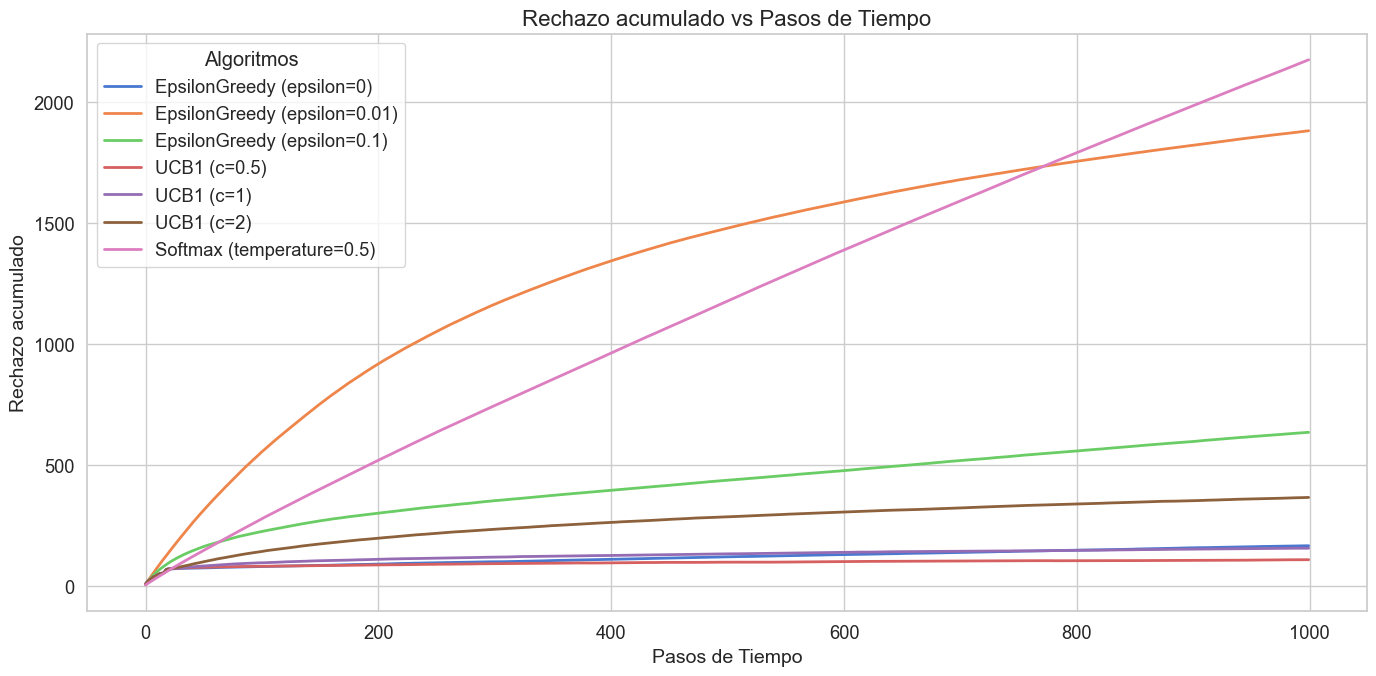

In [11]:
execute_bandit_experiment(k=20, steps=1000, runs=runs, bandit=bandit)

### Valoración de los resultados

Vemos que, para 20 brazos, a los algoritmos les cuesta más identificar cuál es el óptimo, con lo que necesitan, potencialmente, más pasos hasta poder identificarlo. Vemos que para 1000 pasos en general el desempeño si tenemos en cuenta porcentaje de aciertos y rechazo acumulado es peor en todos los casos, lo cual era esperable. Se mantiene, no osbtante, la dominancia por parte de UCB-1 con c=0.5 y c=1 en cuanto a desempeño por encima del resto de vairantes.

### Ejecución de los algoritmos para 2000 steps

A continuación, vamos a repetir el experimento para 2000 pasos, manteniendo el número de runs.

Bandit with 20 arms: ArmNormal(mu=1.76, sigma=1.0), ArmNormal(mu=2.88, sigma=1.0), ArmNormal(mu=3.0, sigma=1.0), ArmNormal(mu=4.11, sigma=1.0), ArmNormal(mu=5.59, sigma=1.0), ArmNormal(mu=5.95, sigma=1.0), ArmNormal(mu=4.49, sigma=1.0), ArmNormal(mu=5.17, sigma=1.0), ArmNormal(mu=7.02, sigma=1.0), ArmNormal(mu=7.29, sigma=1.0), ArmNormal(mu=3.96, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=4.74, sigma=1.0), ArmNormal(mu=7.43, sigma=1.0), ArmNormal(mu=7.91, sigma=1.0), ArmNormal(mu=8.63, sigma=1.0), ArmNormal(mu=5.34, sigma=1.0), ArmNormal(mu=2.11, sigma=1.0), ArmNormal(mu=3.3, sigma=1.0), ArmNormal(mu=7.62, sigma=1.0)
Optimal arm for bandit is: 12 with expected reward=8.8

Algoritmo EpsilonGreedy (epsilon=0): 59.00% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 239.11 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 43.18% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.01): 2329.7

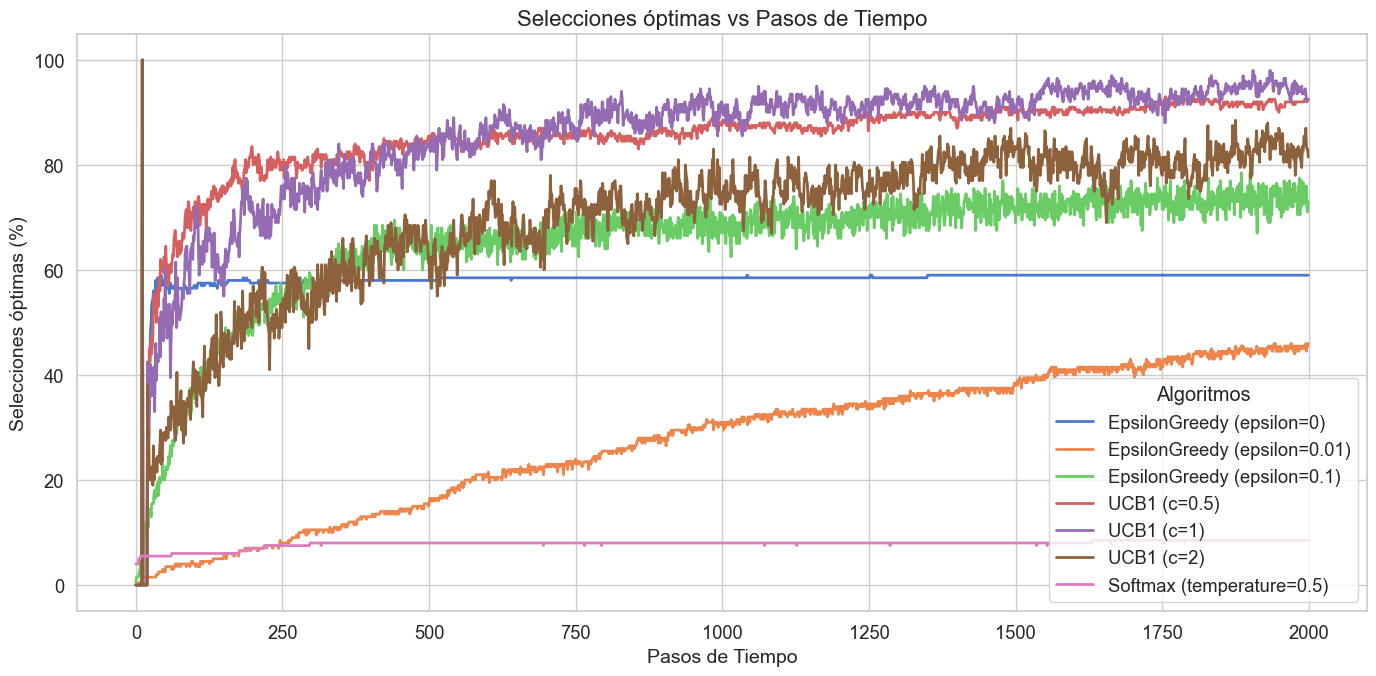

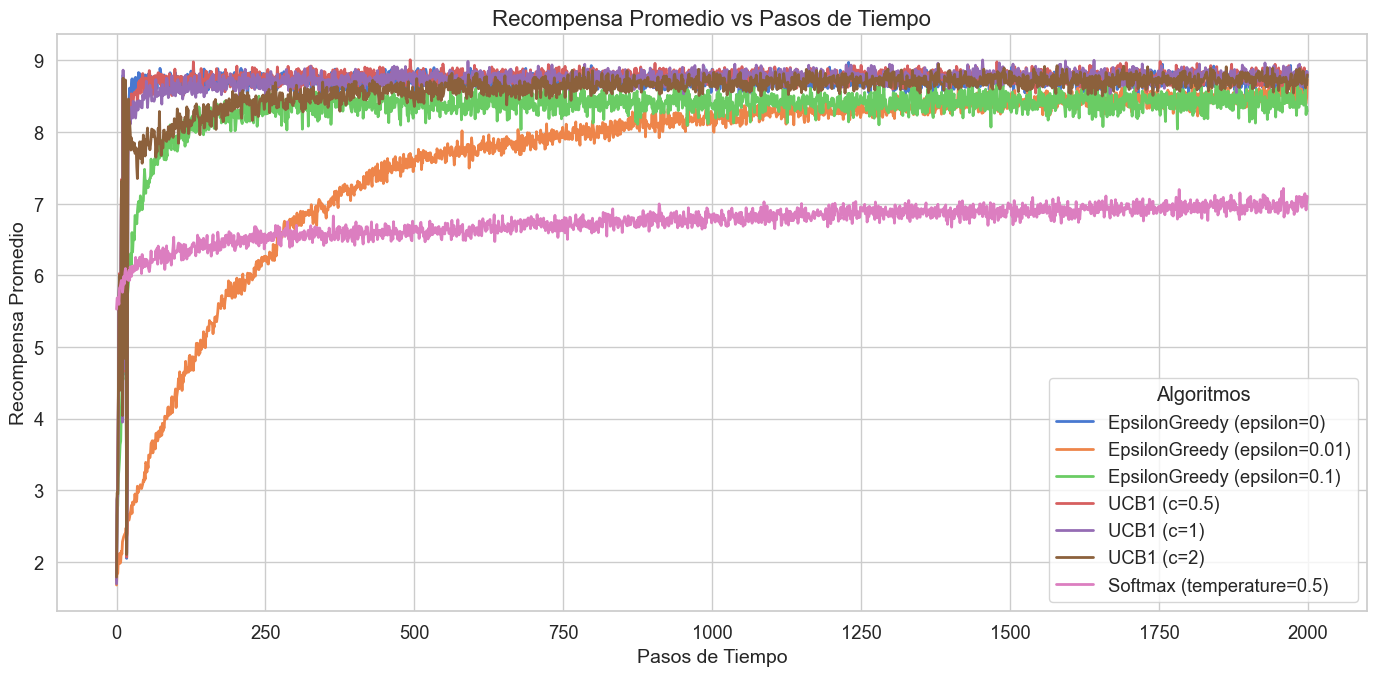

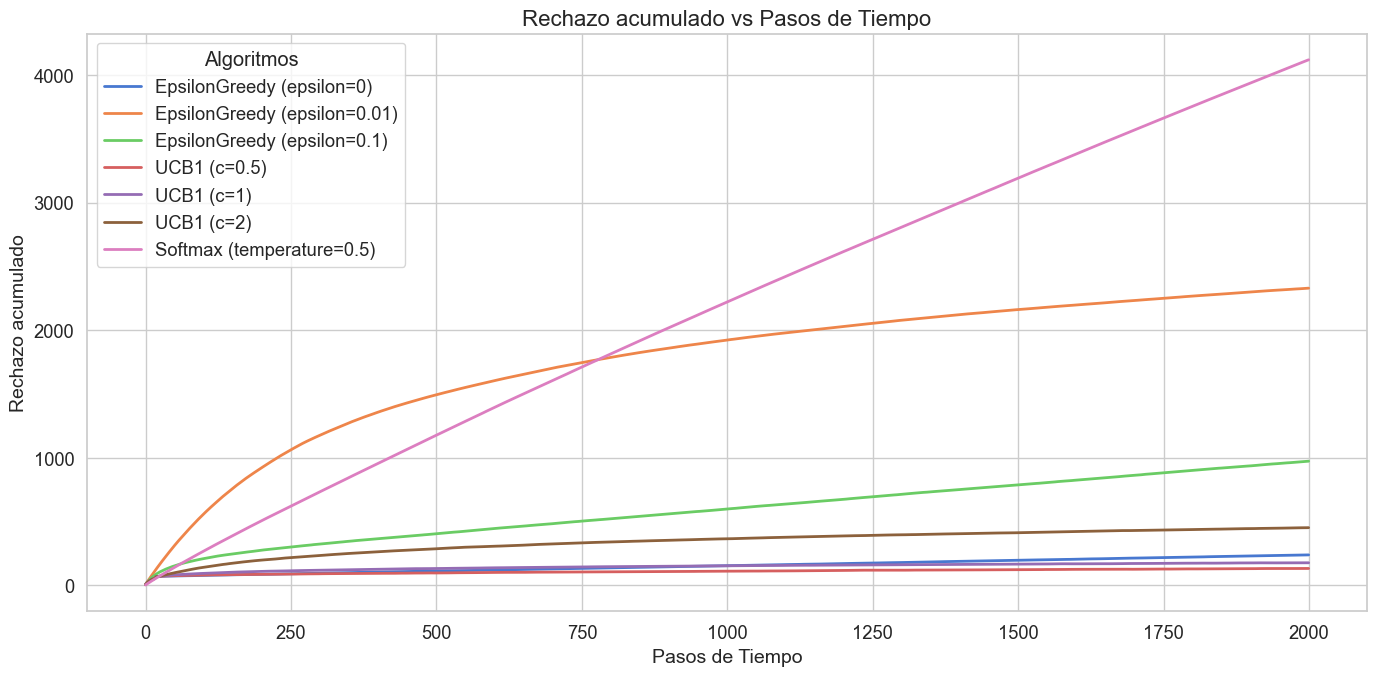

In [12]:
execute_bandit_experiment(k=20, steps=2000, runs=runs, bandit=bandit)

### Valoración de los resultados

Confirmamos lo que comentamos en el apartado anterior. Para 2000 pasos, parece que se ha dado tiempo a que los algoritmos evolucionen hacia un comportamiento más deseable, llegando a conseguir enel caso de las variantes de UCB-1 con c < 2 unos resultados equiparables incluso al caso con 10 brazos. Para la variante de UCB-1 con c=2 parece que el mayor peso de la componente exploratoria penaliza el hecho de "quedarse" con el brazo óptimo.

Las variantes basadas en epsilon han demostrado no "aprender" tan bien y se quedan sensiblemente por debajo. Epsilon-Greedy con epsilon=0 mantiene su comportamiento de estancarse.

Vemos en todos los casos como el arrepentimiento acumulado es mayor que en el caso de 10 brazos puesto que los algoritmos se "equivocan" mucho más antes de llegar a aprender cuál es el brazo óptimo.

## Ejecución del experimento para Variante 3 del bandido

Por último, vamos a comparar los distintos algoritmos para una última variante del bandido de k-brazos. Vamos a mantener el número de brazos a 20.

Sin embargo, vamos a cambiar la desviación del bandido con respecto a la original de 1.0, a otras mayores, de forma que sea más difícil identificar cuál es el brazo que mayor recompensa otorga por parte de los distintos algoritmos. Debido a que los algoritmos van a necesitar potencialmente más tiempo en identificar la rama ganadora, las ejecuciones para distintas desviaciones serán siempre con 2000 pasos.

Como la desviación estándar ahora es mayor, vamos a cambiar el rango de valores de las recompensas para acomodarlo mejor a los nuevos valores de las desviaciones. Ahora el rango va a estar comprendido entre 20 y 100.

Bandit with 20 arms: ArmNormal(mu=20.15, sigma=5.0), ArmNormal(mu=22.75, sigma=5.0), ArmNormal(mu=29.82, sigma=5.0), ArmNormal(mu=41.36, sigma=5.0), ArmNormal(mu=42.17, sigma=5.0), ArmNormal(mu=42.42, sigma=5.0), ArmNormal(mu=45.86, sigma=5.0), ArmNormal(mu=51.04, sigma=5.0), ArmNormal(mu=58.75, sigma=5.0), ArmNormal(mu=58.86, sigma=5.0), ArmNormal(mu=60.07, sigma=5.0), ArmNormal(mu=69.94, sigma=5.0), ArmNormal(mu=72.57, sigma=5.0), ArmNormal(mu=73.84, sigma=5.0), ArmNormal(mu=75.62, sigma=5.0), ArmNormal(mu=80.12, sigma=5.0), ArmNormal(mu=88.18, sigma=5.0), ArmNormal(mu=89.9, sigma=5.0), ArmNormal(mu=95.49, sigma=5.0), ArmNormal(mu=99.86, sigma=5.0)
Optimal arm for bandit is: 20 with expected reward=99.86

Algoritmo EpsilonGreedy (epsilon=0): 87.50% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 1944.93 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 58.39% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGree

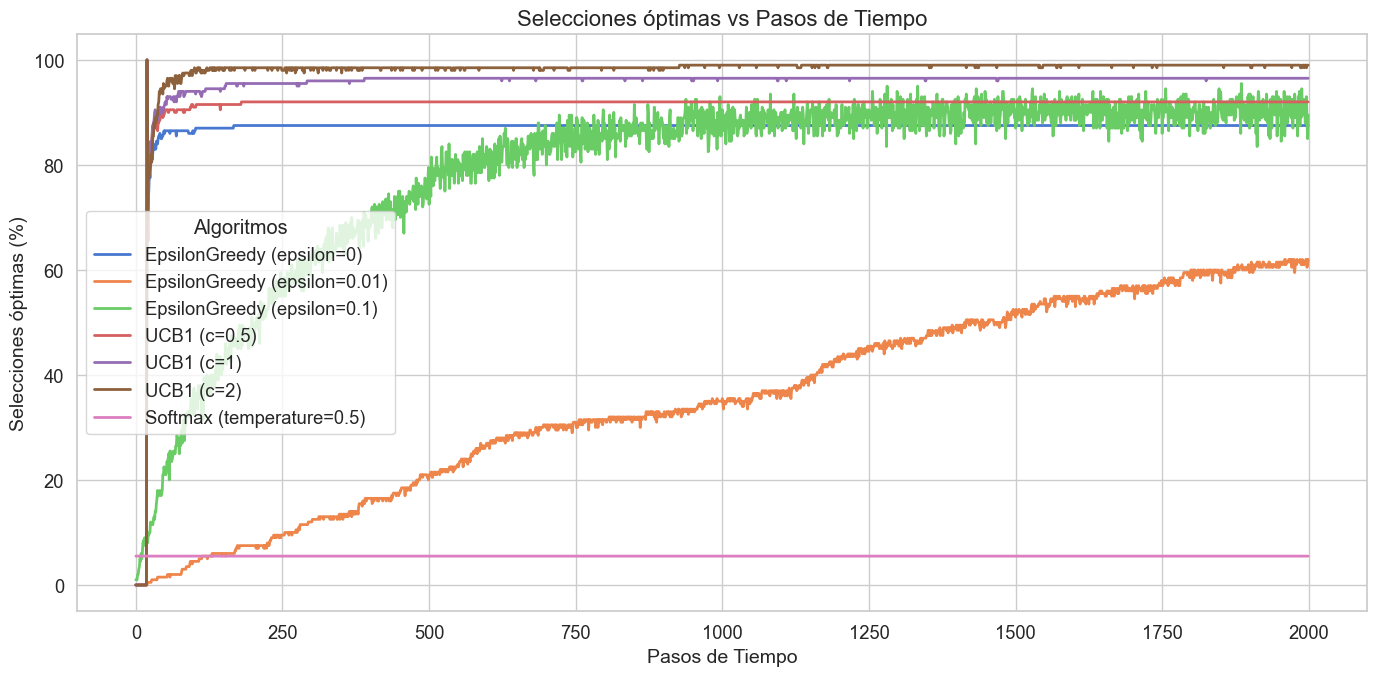

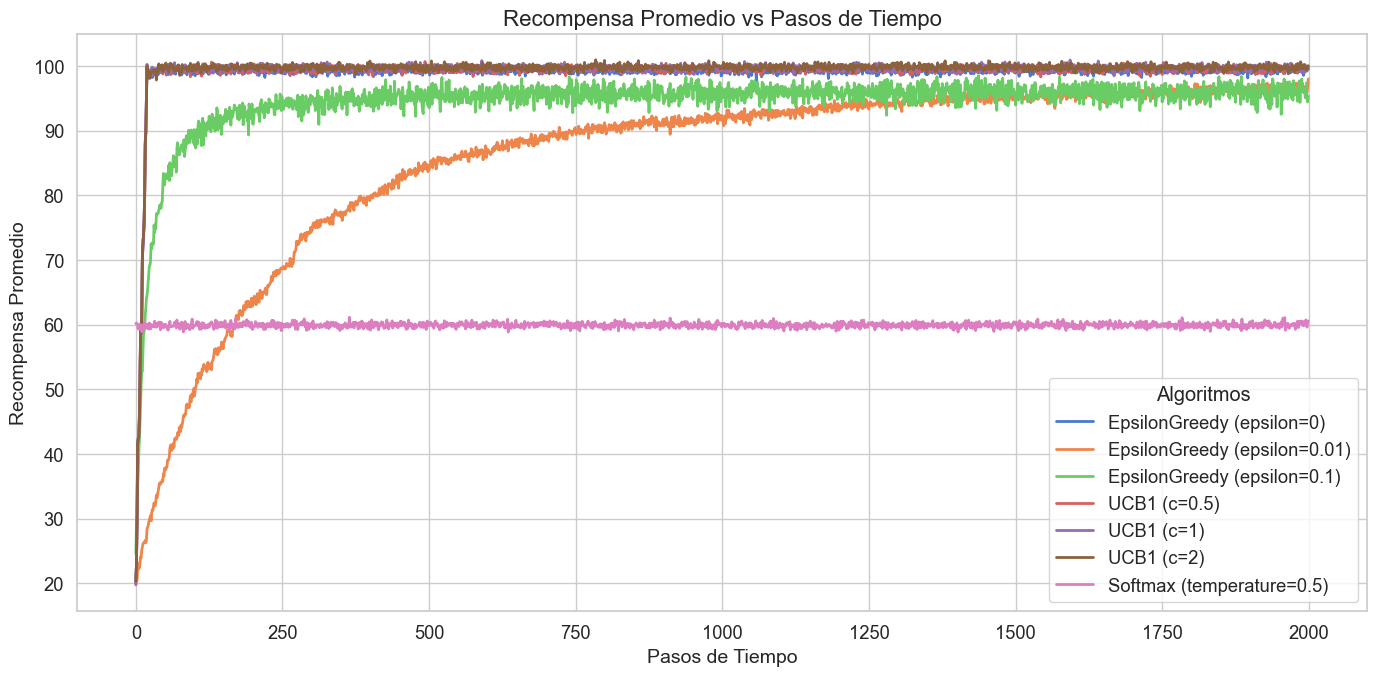

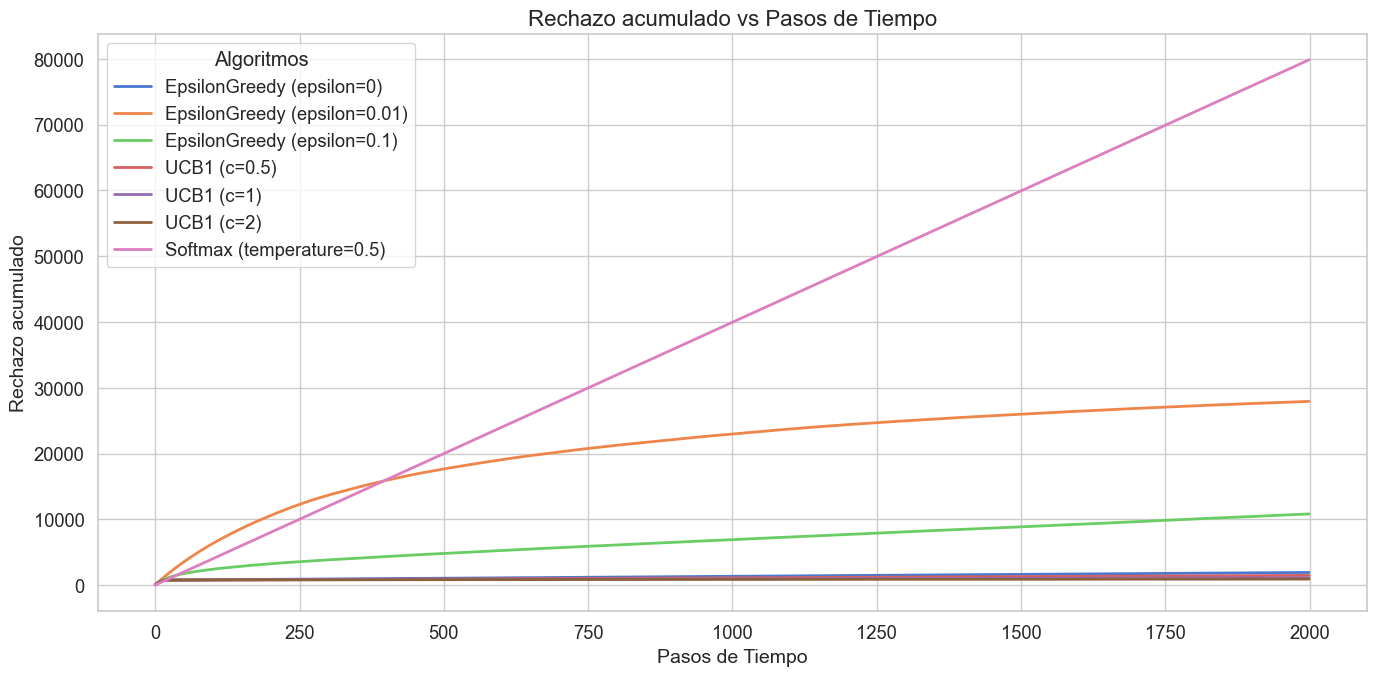

In [13]:
# Definimos el bandido (se comparte entre experimentos)
bandit = Bandit(arms=ArmNormal.generate_arms(k=20, mu_min=20, mu_max=100, sigma=5.0)) # Generar un bandido con k brazos de distribución normal. El valor de máxima recompensa será 10
execute_bandit_experiment(k=20, steps=2000, runs=runs, bandit=bandit)


### Valoración de los resultados

En este caso, al aumentar la desviación estándar a 5, y por tanto el ruido entre las recompensas aportadas por cada uno de los 20 brazos, vemos como, en el caso de las variantes de Epsilon-Greedy, tardan bastante más en llegar a un valor de porcentage de aciertos que cuando la desviación era menor. En este caso, la que mejor se comporta vuelve a ser la variante con epsilon=0.1, debido al mayor peso de la componente exploratoria, pero, aún así, se queda relativamente alejada de las variantes de UCB.

Las variantes de UCB parecen ser las que antes encuentran el brazo que mayor recompensa otorga, lo que vuelve a confirmar en este experimento que generalmente son las más deseables. Además, podemos ver como lo encuentran en un número relativamente comedido de pasos.

Bandit with 20 arms: ArmNormal(mu=20.15, sigma=10.0), ArmNormal(mu=22.75, sigma=10.0), ArmNormal(mu=29.82, sigma=10.0), ArmNormal(mu=41.36, sigma=10.0), ArmNormal(mu=42.17, sigma=10.0), ArmNormal(mu=42.42, sigma=10.0), ArmNormal(mu=45.86, sigma=10.0), ArmNormal(mu=51.04, sigma=10.0), ArmNormal(mu=58.75, sigma=10.0), ArmNormal(mu=58.86, sigma=10.0), ArmNormal(mu=60.07, sigma=10.0), ArmNormal(mu=69.94, sigma=10.0), ArmNormal(mu=72.57, sigma=10.0), ArmNormal(mu=73.84, sigma=10.0), ArmNormal(mu=75.62, sigma=10.0), ArmNormal(mu=80.12, sigma=10.0), ArmNormal(mu=88.18, sigma=10.0), ArmNormal(mu=89.9, sigma=10.0), ArmNormal(mu=95.49, sigma=10.0), ArmNormal(mu=99.86, sigma=10.0)
Optimal arm for bandit is: 20 with expected reward=99.86

Algoritmo EpsilonGreedy (epsilon=0): 73.50% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 3722.29 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 52.93% de elecciones óptimas en el 20% último de steps
A

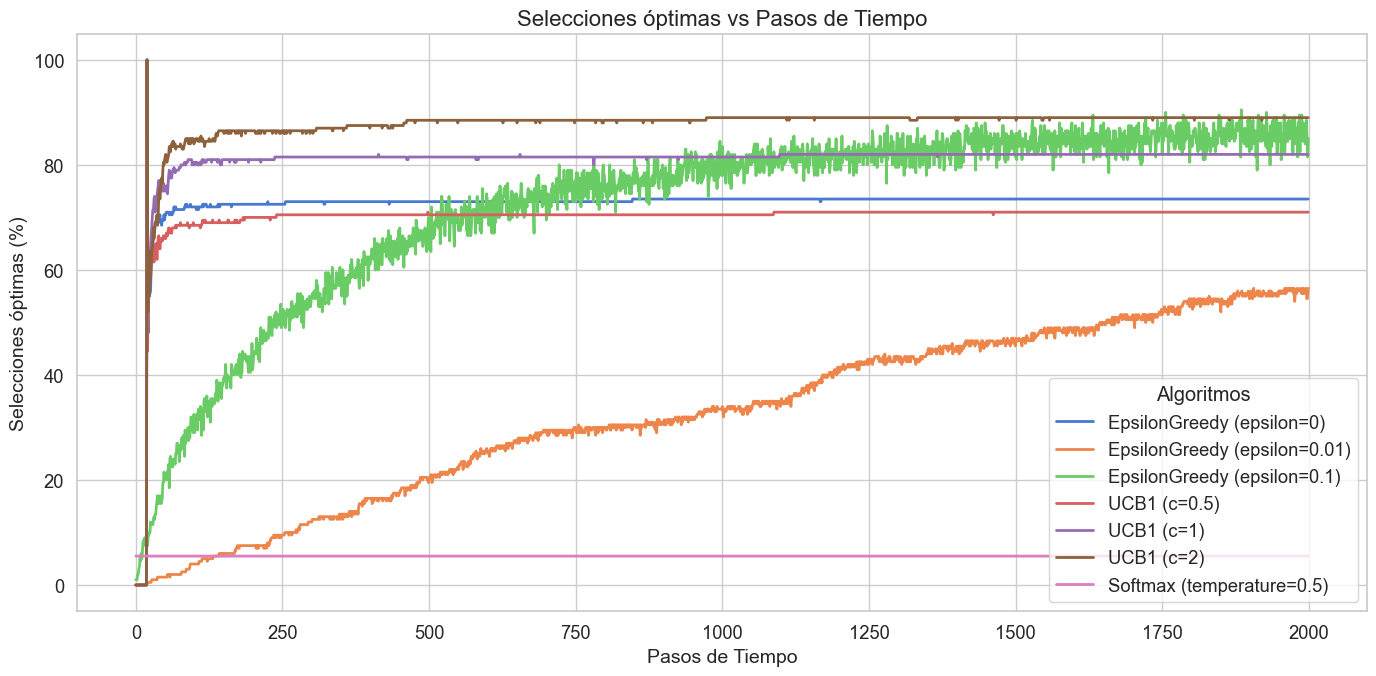

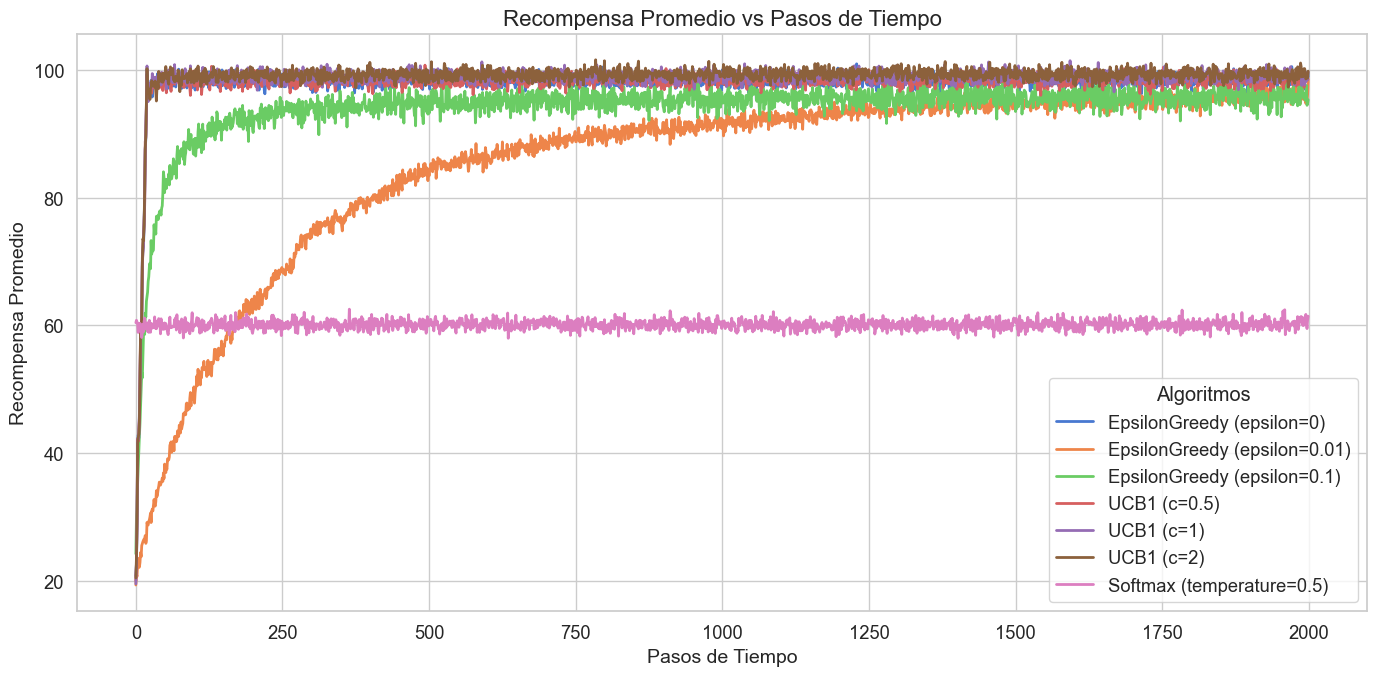

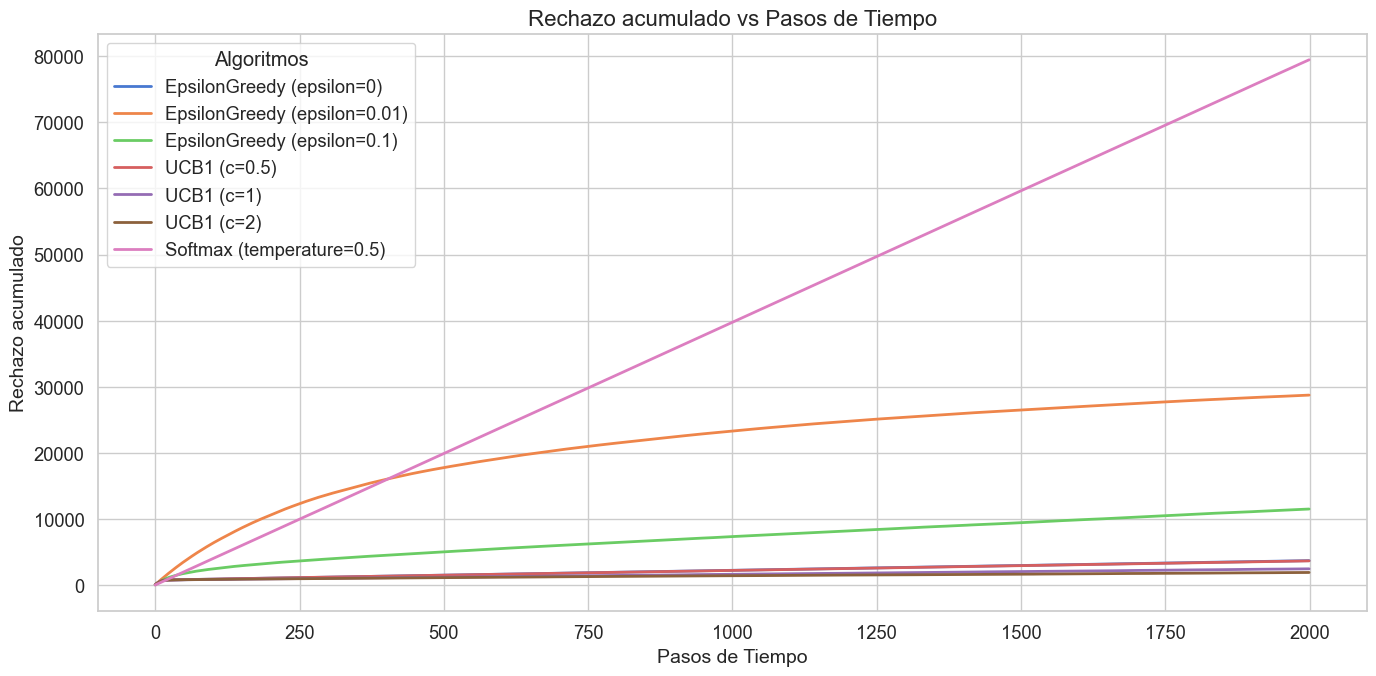

In [14]:
bandit = Bandit(arms=ArmNormal.generate_arms(k=20, mu_min=20, mu_max=100, sigma=10.0)) # Generar un bandido con k brazos de distribución normal. El valor de máxima recompensa será 10
execute_bandit_experiment(k=20, steps=2000, runs=runs, bandit=bandit)


### Valoración de los resultados

En este último experimento, donde hemos aumentado la desviación a 10, el ruido entre recompensas aportadas por cada brazo ha sido mucho mayor al caso anterior.

Vemos como incluso las variantes del algoritmo UCB-1 han tenido dificultades para distinguir el brazo ganador, quedándose las de menor valor de c con un porcentaje menor de aciertos, y viéndose beneficiada en este caso la variante con un c=2 (que presenta mayor comportamiento exploratorio).

Las variantes de Epsilon-Greddy por lo general se comportan peor, exceptuando a aquella con epsilon=0.1, que sigue explorando hasta acercarse incluso a UCB-1 con c=2, lo que demuestra que, en entornos con un ruido creciente, se comportan mejor los algoritmos con una mayor componente exploratoria y que tratan de explotar menos una solución concreta.

## Conclusiones

Hemos realizado distintos experimentos para el bandido de k-brazos siguiendo una distribución normal:

*  Experimento para bandido con K=10, steps=1000, sigma=1
*  Experimento para bandido con K=10, steps=2000, sigma=1
*  Experimento para bandido con K=20, steps=1000, sigma=1
*  Experimento para bandido con K=20, steps=2000, sigma=1
*  Experimento para bandido con K=20, steps=2000, sigma=5
*  Experimento para bandido con K=20, steps=2000, sigma=10

En todos los casos se han comparado distintas variantes del algoritmo Epsilon-Greedy, con epsilon=[0, 0.01, 0.1], el algoritmo UCB-1 con c=[0.5, 1, 2], y el algoritmo Softmax. Los parámetros han sido siempre los mismos para asegurar la consistencia de los resultados.

Siendo así, tenemos que, en todos los casos, exceptuando el último, los algoritmos que mejor comporamiento (Porcentaje de aciertos en último 20% de pasos vs rechazo acumulado) ha presentado han sido los algoritmos UCB-1 con c=0.5 y c=1. En el último caso, con sigma=10, hemos visto como la variante UCB-1 con c=2 ha presentado un comportamiento significativamente mejor que el resto de algoritmos.

Para los algoritmos Epsilon-Greedy, vemos como interesa tener un nivel de exploración moderado (ej. epsilon=0.1) para obtener los mejores resultados, aunque suelen quedar sensiblemente por debajo de los resultados de UCB-1.

Por último, denotar que, cuando aumenta la desviación en una distribución normal, los algoritmos que realizan una mayor exploración han resultado ser los que mejor se comportan. Siendo así, elegiríamos por lo general el algoritmo de **UCB-1** para el caso presente, modificando el coeficiente de exploración a conveniencia según el ruido que se expere que exista en los datos.
